# **ViVAE analysis of scRNA-seq data**

**Maintainer: [David Novak](https://davnovak.github.io/)**

This is a tutorial on using *ViVAE* to analyse single-cell RNA sequencing (scRNA-seq) data.
It covers the generation of structure-preserving embeddings and their interpretation, a comparison to *t*-SNE and *UMAP* plots and multiple forms of evaluation.

If you lack the computational resources to run this analysis on your computer, you can run Jupyter notebooks like this remotely with a Google account, using Google Colab.
Moreover, you can read and write data on your Google Drive, making it easy to test ViVAE and other algorithms, including scoring evaluation via [ViScore](https://github.com/saeyslab/ViScore), on publicly available datasets.

We recommend the [Single Cell Portal](https://singlecell.broadinstitute.org/single_cell) and the [CELLxGENE](https://cellxgene.cziscience.com/) database for downloading high-quality scRNA-seq data.

<details>
<summary><b>Running ViVAE in the cloud</b></summary>

Feel free to save a copy of this notebook in your Google Drive (`File > Save a copy in Drive`), optionally adapt the code given here and test ViVAE with the default dataset or others that you download (via the `wget` command below) or upload (via your browser's interface) to your Drive as H5AD files.

**Make sure you are using GPU for this analysis (`Runtime -> Change runtime type -> T4 GPU`).**

To mount your Google Drive from Colab, you'll need to run:

```
from google.colab import drive
drive.mount('/content/gdrive')
```

<hr>
</details>

<details>
<summary><b>Running ViVAE locally</b></summary>

To run this locally with your dataset of choice, first install ViVAE by following the [instructions](https://github.com/saeyslab/ViVAE/blob/main/README.md) in our GitHub repository, then download this notebook (`File > Download > Download .ipynb`).
Then make sure you can [open Jupyter notebooks](https://docs.jupyter.org/en/latest/install/notebook-classic.html) and use your ViVAE conda environment with them.

<hr>
</details>

<details>
<summary><b>Using ViVAE with cytometry data</b></summary>

The ViVAE [repository](https://github.com/saeyslab/ViVAE) on GitHub contains a notebook called `example_cytometry.ipynb` with a workflow for dimensionality reduction of flow and mass cytometry data, as well as a sample dataset.

For downloading publicly available annotated cytometry datasets, we recommend the [HDCytoData](https://www.bioconductor.org/packages/release/data/experiment/html/HDCytoData.html) R package.
The pre-processed expression data can then be saved into a CSV file or a NumPy binary (`.npy`) using [reticulate](https://rstudio.github.io/reticulate/) in your R session.

<hr>
</details>

<details>
<summary><b>Benchmarking & hyperparameter tuning</b></summary>

If you have access to a high-performance computing (HPC) cluster, you can set up a systematic benchmark of different DR methods using our framework [here](https://github.com/saeyslab/ViScore/tree/main/benchmarking).

In addition to comparing different algorithms, the framework can be used for hyperparameter tuning, *ie.* to find out what set-up is ideal for your DR method of choice.

</details>

<hr>

## **0.** Set-up

We start by installing required packages (with some dependencies):

* `scanpy`: for pre-processing of the scRNA-seq expression data
* `ViVAE`: for dimensionality reduction, plotting and evaluation of distortions via encoder indicatrices
* `umap` and `sklearn`: to create alternative embeddings to the one obtained from ViVAE (UMAP, t-SNE)
* `ViScore`: for unsupervised and supervised evaluation of embeddings
* `flowsom`: for high-dimensional data clustering and construction of a minimum spanning tree (MST) to get a graph-based view of the data

Your installation procedure may depend slightly on your Python version or virtual environment.
If you are running this from Google Colab, you can install Python packages using the `%%bash` cell magic:

In [1]:
%%bash
pip install scanpy
pip install pytometry
pip install pandas
pip install scikit-learn
pip install git+https://github.com/saeyslab/FlowSOM_Python.git
pip install git+https://github.com/saeyslab/ViVAE.git
pip install "dask[dataframe]" --upgrade
pip install pyemd==1.0.0
pip install git+https://github.com/saeyslab/ViScore.git
pip install umap-learn==0.5.6

In [1]:
## Package imports

import scanpy as sc
import numpy as np
import flowsom as fs
import torch
import ViVAE
import umap
from sklearn.manifold import TSNE
import ViScore
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import copy

/Users/davidnovak/miniforge3/envs/ViVAE/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next, we download [this](https://cellxgene.cziscience.com/e/c05fb583-eb2f-4e3a-8e74-f9bd6414e418.cxg/) thymus scRNA-seq dataset from the following study:

The Tabula Sapiens Consortium. **The Tabula Sapiens: A multiple-organ, single-cell transcriptomic atlas of humans**. Science 376, eabl4896(2022). DOI:10.1126/science.abl4896

You can download the `.h5ad` file manually using your browser, or run the command below if using Colab:

In [2]:
%%bash
wget -O ./scrnaseq.h5ad https://datasets.cellxgene.cziscience.com/f56e0393-c2f3-42f3-93f1-7c8a4ee49d75.h5ad >/dev/null 2>&1

## **1.** Pre-processing of input data

Using `scanpy` we import the expression data, apply some basic scaling and use principal component analysis (PCA) as a common pre-processing step ahead of the non-linear dimension reduction step.

In [2]:
hd = sc.read_h5ad('./scrnaseq.h5ad')

## If the data matrix contained cell counts, we would run:
# sc.pp.normalize_total(hd)     # min-max scaling per cell
# sc.pp.log1p(hd)               # x := log(1+x) transformation

sc.pp.scale(hd, max_value=10.) # z-standardisation of data
sc.tl.pca(hd, svd_solver='arpack', n_comps=100)
  # principal component analysis to capture most variability in data
pc = hd.obsm['X_pca']

We can also extract cell type labels here provided by the authors.
These will typically be included as one of the columns of the `hd.obs` data frame.

In [3]:
labs = np.array(hd.obs['cell_type'])
  # with different datasets, change 'cell_type' to appropriate column name

At this point, we can delete the original `hd` object from memory.

In [4]:
del hd

Now let's construct a *k*-nearest neighbour graph (k-NNG) and use it to denoise our PCA-transformed inputs. This increases local structure preservation in the lower-dimensional embedding downstream, resulting in visualisation of a more sharply defined skeleton of the point cloud.

**Note:** You might also be interested in experimenting with other denoising techniques, *e.g.,* [MAGIC](https://github.com/KrishnaswamyLab/MAGIC) or [DCA](https://github.com/theislab/dca).

In [5]:
## Find nearest neighbours of each point (approximate)
knn = ViVAE.make_knn(x=pc, k=1000, fname='scrnaseq_knn.npy')
  # k-NNG is loaded if already saved previously

## Denoise PCA-transformed data based on k-NN relations
pc_denoised = ViVAE.smooth(x=pc, knn=knn, k=50, coef=1., n_iter=1)

Loading k-NNG


## **2.** Dimensionality reduction

Next we will set up a ViVAE model: a parametric dimension-reduction model based on a regularised variational autoencoder (VAE).

We will train it to learn a non-linear transformation of our high-dimensional (HD) data into a lower-dimensional (LD) smooth latent space, achieving structure-preserving dimensionality reduction.

The training is done using a combined loss function consisting of three terms:

- **reconstruction error**: measures reconstruction of original data by decoder from LD representation sampled from the latent space

- **KL-divergence from latent prior**: divergence from isotropic Gaussian latent prior using reparametrisation to maintain a smooth latent space (read more [here](https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important))

- **MDS (quartet) loss**: for joint optimisation of relative intra-quartet distances between repeatedly and randomly sampled points (see [SQuadMDS](https://dial.uclouvain.be/pr/boreal/object/boreal:264665) for original idea behind this)

We implement some other possible loss functions.
You can read about them in the documentation by running:
```
help(ViVAE.ViVAE)
```

Some tips on hyperparameter tuning:

- Increase number of epochs (`n_epochs`) for better convergence or decrease it for shorter running times.

- Increase batch size (`batch_size`) for faster training, decrease it for less memory usage.

- Optimiser parameters (`learning_rate` and `weight_decay`) can be increased to speed up training, at the risk of instability and sub-optimal solutions.

In [6]:
np.random.seed(42)
torch.manual_seed(42)
model = ViVAE.ViVAE( # init model
    input_dim=pc.shape[1],
    latent_dim=2,
    random_state=42
)
model.fit( # train model
    X=pc_denoised,
    n_epochs=100,
    batch_size=512,
    verbose=False
)

We can now easily plot the 2-dimensional embedding using a colour scheme for points based on the cell population labels we extracted earlier.

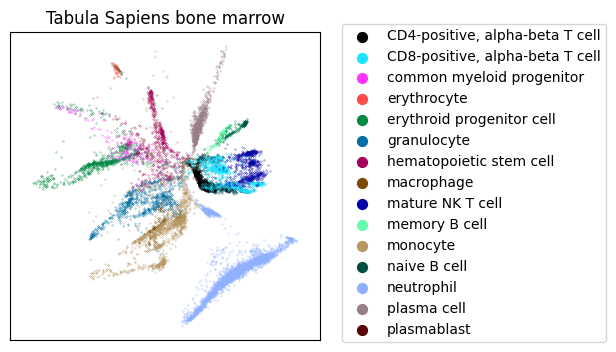

In [7]:
emb = model.transform(pc_denoised)
fig, ax = ViVAE.plot_embedding(emb, labels=labs, show=False)
ax.set_title('Tabula Sapiens bone marrow')
fig.set_figheight(4)
fig.set_figwidth(4)
fig

It is also fairly easy to display some major cell compartments\lineages separately to show the overall layout.

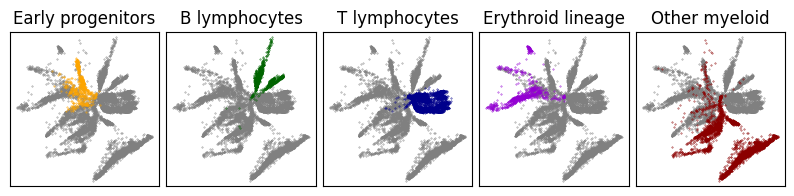

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10,2))
fig.subplots_adjust(wspace=.05)

cell_subsets = ['Early progenitors', 'B lymphocytes', 'T lymphocytes', 'Erythroid lineage', 'Other myeloid']
idcs = [
    np.array(['stem cell' in lab or 'progenotor' in lab for lab in labs]),
    np.array(['B cell' in lab or 'plasma' in lab for lab in labs]),
    np.array(['T cell' in lab for lab in labs]),
    np.array(['erythro' in lab for lab in labs]),
    np.array([lab in ['neutrophil', 'macrophage', 'monocyte'] for lab in labs])
]
colours = ['orange', 'darkgreen', 'darkblue', 'darkviolet', 'darkred']

for i in range(len(idcs)):
    ax[i].scatter(emb[np.bitwise_not(idcs[i]),0], emb[np.bitwise_not(idcs[i]),1], c='grey', s=.1)
    ax[i].scatter(emb[idcs[i],0], emb[idcs[i],1], c=colours[i], s=.1)
    ax[i].tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax[i].axis('equal')
    ax[i].set_title(cell_subsets[i])

## **3.** Evaluating local distortions

We can also compute and plot the encoder indicatrices, *ie.* objective indicators of local directed stretching of the data 2-manifold. These are based on, but separate and different from, decoder indicatrices as implemented in [Geometric Autoencoders](https://github.com/phnazari/GeometricAutoencoder); DOI: [arXiv:2306.17638](https://arxiv.org/abs/2306.17638).

Indicatrices are small, equally large hyperspheres in the original, high-dimensional (HD) space (they lie in the [horizontal tangent space](https://gemini.google.com/share/9d567cee0c08) of existing data points).

As they are passed through the encoder, they can get distorted in two different ways. Firstly, their size can vary across the embedding, including relative stretching or contraction of some parts of the points cloud. Secondly, their shape can change (from sphere to ellipsis), which indicates the specific direction along which the distortion occurs.

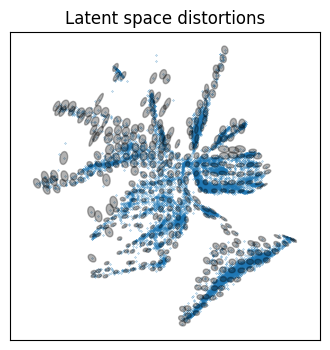

In [9]:
ei_nice = model.encoder_indicatrices(X=pc_denoised, radius=1e-3, n_steps=30, n_polygon=200)
fig, ax = ViVAE.plot_indicatrices(indicatrices=ei_nice, scale_factor=4e2, figsize=(6,6), show=False)
ax.set_title('Latent space distortions')
fig.set_figheight(4)
fig.set_figwidth(4)
fig

As examples of distortion, we can see there is some artificial shrinking of the part of the embedding containing monocytes and other granulocytes, and some 'run-away' stretching effect in the plasma cells.

<hr>

The hyperspheres should have a small radius (radius in `model.encoder_indicatrices`), but not so small that the resulting shapes in the plot have sharp, as opposed to smooth, edges.

If the radius is set too large, the resulting plot may show a C-shape, S-shape or other deformation of an ellipsis, in place of the ellipses we can see above. This is because the hyperspheres reach too far away from the data points and capture deformation outside the horizontal tangent space. Such a visualisation is typically less informative.

Note that the `scale_factor` in `plot_indicatrices` needs to be adapted for a good plot (ie. indicatrices should be plotted large enough to be informative, but small enough to not have too much overlap).

These are some additional arguments you can alter:

- `n_steps` in `encoder_indicatrices` determines the density of indicatrices (which are sampled on a grid). Higher values will ensure better coverage of the space, but cause a more cluttered plot.

- `n_polygon` in `encoder_indicatrices` determined how many points per indicatrix are sampled. Higher values will ensure higher-quality graphical output, but may increase execution time if extremely high.

## **4.** FlowSOM integration

Although designed originally for cytometry data analysis, FlowSOM has emerged as one of the go-to methods for clustering of single-cell datasets.
Thanks to this, many researchers are used to interpreting the outputs of FlowSOM analyses.
If you are one of them, you can apply automated clustering to the original expression data and see how concordant the ViVAE embedding is with your FlowSOM tree.

First, let's train a FlowSOM model on the expression data.

In [10]:
## Wrap PCA-reduced data in an AnnData object
hdf = ad.AnnData(pc)
colnames = [f'PC{i+1}' for i in range(pc.shape[1])]
hdf.var = pd.DataFrame(
      {'n': range(pc.shape[1]), 'channel': colnames, 'marker': colnames}
  )

## Run FlowSOM
fsom = fs.FlowSOM(hdf, n_clusters=40, xdim=12, ydim=12, seed=42)

2024-08-28 22:00:06.707 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2024-08-28 22:00:06.709 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2024-08-28 22:00:09.099 | DEBUG    | flowsom.main:__init__:88 - Updating derived values.


Now we can easily map the FlowSOM minimum spanning tree (MST) onto our embedding, obtaining a more comprehensive view of our data for our downstream analyses.

For instance, we can check the concordance of the FlowSOM tree topology with our embedding.

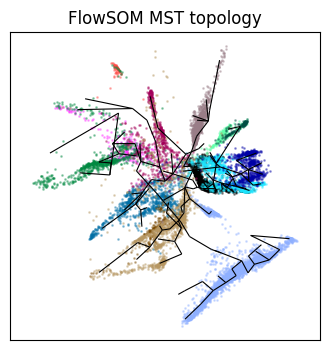

In [11]:
fig, ax = ViVAE.plot_embedding(embedding=emb, labels=labs, s=1., fsom=fsom, dr_model=model, fsom_show_nodes=False, show=False)
ax.get_legend().remove()
ax.set_title('FlowSOM MST topology')
fig.set_figheight(4)
fig.set_figwidth(4)
fig

The MST topology is only partially concordant with cell developmental lineages.
Furthermore, erythrocytes are not separated into a separate cluster (no node of the tree is anchored in the red island at the top-left of the embedding).

<hr>

We can also view the composition of FlowSOM clusters in terms of manually labelled populations.

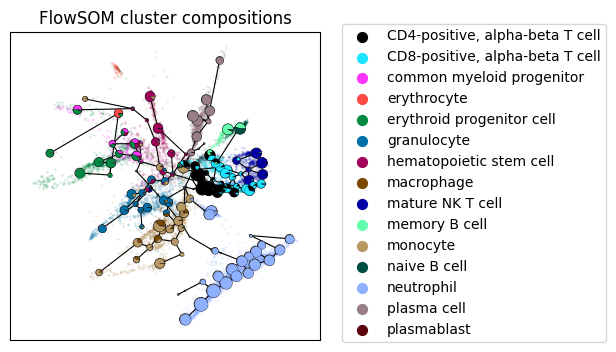

In [12]:
fig, ax = ViVAE.plot_embedding(embedding=emb, labels=labs, s=.1, fsom=fsom, fsom_node_scale=.01, dr_model=model, show=False)
ax.set_title('FlowSOM cluster compositions')
fig.set_figheight(4)
fig.set_figwidth(4)
fig

We can now see that erythrocytes were clustered together with erythroid progenitors.
The separation of a partially distinct island of hematopoietic stem cells by ViVAE is supported by the FlowSOM clustering.
A further analysis of differential expression would reveal a distinct phenotype responsible for this separation.

<hr>

We can check out how the top PC values vary across the embedding, revealing what kind of variation the top components capture.

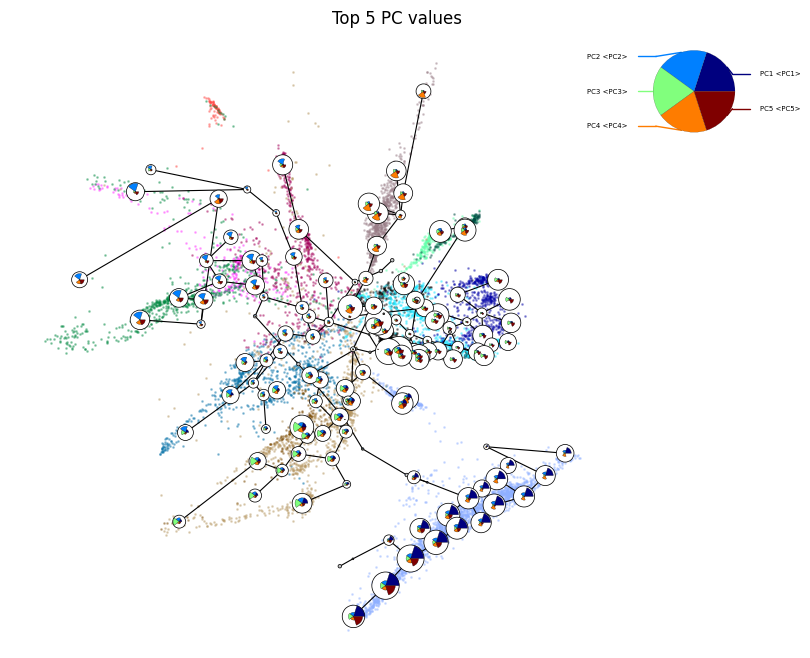

In [13]:
fig, ax = ViVAE.plot_embedding(embedding=emb, labels=labs, s=1., fsom=fsom, fsom_node_scale=.01, dr_model=model, fsom_view='markers', fsom_markers=['PC1','PC2','PC3','PC4', 'PC5'], show=False)
ax.set_title('Top 5 PC values')
fig.set_figheight(8)
fig.set_figwidth(10)
fig

We can see that PC1 separates neutrophils (high values) from monocytes (medium values) and the rest of the cells.
High PC2 values roughly separate out erythroid cells from the rest.
Monocytes are isolated by high PC3 values.
Plasma cells are distinguishable by high PC4 values.
PC5 is less straightforward to interpret.

<hr>

There are other options for this type of plotting.
Check out `help(ViVAE.plot_embedding)`.

## **5.** Visual comparison of *t*-SNE, *UMAP* and *ViVAE*

Next, we will generate a *t*-SNE and *UMAP* embedding to compare with the one we obtained from ViVAE.
We use default settings for each method, and non-denoised inputs (in our paper we evaluate both methods with the use of denoising as well).
This can be tinkered with.

In [14]:
## t-SNE embedding
model_tsne = TSNE(n_components=2, perplexity=30., random_state=42)
emb_tsne = model_tsne.fit_transform(pc)

In [15]:
## UMAP embedding
model_umap = umap.UMAP(random_state=42) # this disables multi-threading, making UMAP run slower
model_umap.fit(pc)
emb_umap = model_umap.transform(pc)

/Users/davidnovak/miniforge3/envs/ViVAE/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


We can use the ViVAE plotting function to conveniently display the t-SNE and UMAP embeddings also.

(We can also easily superimpose the FlowSOM MST over the UMAP embedding, since the model has a `.transform` method.
This is not possible with the t-SNE plot.)

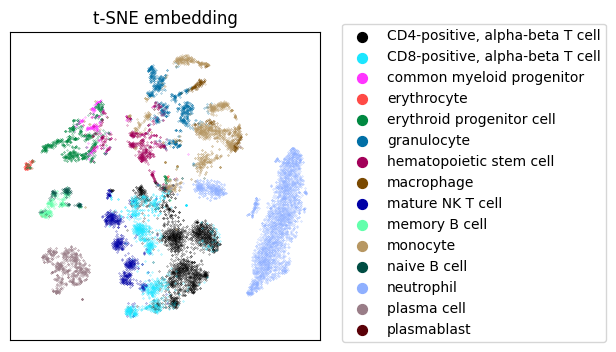

In [16]:
fig_tsne, ax_tsne = ViVAE.plot_embedding(emb_tsne, labels=labs, show=False)
ax_tsne.set_title('t-SNE embedding')
fig_tsne.set_figheight(4)
fig_tsne.set_figwidth(4)
fig_tsne

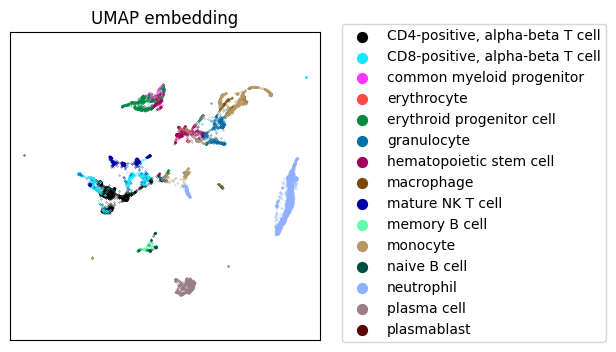

In [17]:
fig_umap, ax_umap = ViVAE.plot_embedding(embedding=emb_umap, labels=labs, show=False)
ax_umap.set_title('UMAP embedding')
fig_umap.set_figheight(4)
fig_umap.set_figwidth(4)
fig_umap

We also produce an ad-hoc plot to locate erythrocytes in the UMAP embedding, since they are notably separated into two completely disjoint islands.

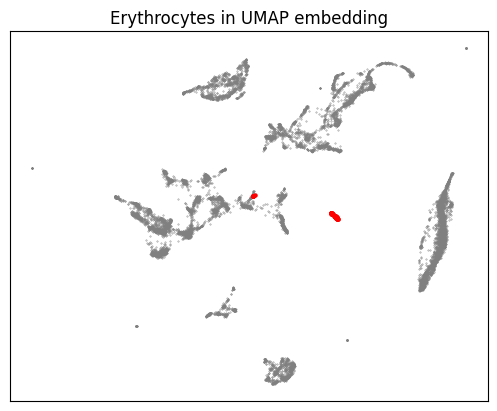

In [18]:
plt.scatter(emb_umap[:,0], emb_umap[:,1], c='gray', s=.1)
plt.scatter(emb_umap[np.array(labs=='erythrocyte'),0], emb_umap[np.array(labs=='erythrocyte'),1], c='red', s=5.)
plt.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title('Erythrocytes in UMAP embedding')
plt.draw()

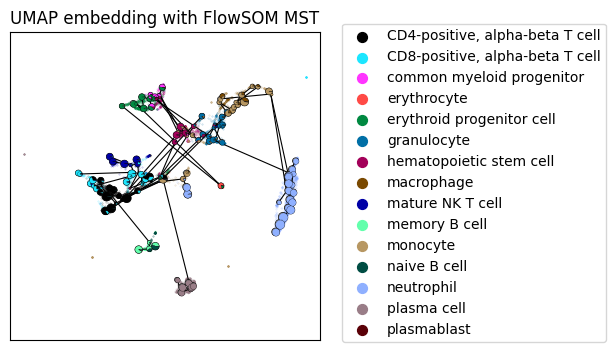

In [19]:
fig_umap, ax_umap = ViVAE.plot_embedding(embedding=emb_umap, labels=labs, s=.1, fsom=fsom, fsom_node_scale=.01, dr_model=model_umap, show=False)
ax_umap.set_title('UMAP embedding with FlowSOM MST')
fig_umap.set_figheight(4)
fig_umap.set_figwidth(4)
fig_umap

<hr>

We can now compare what the lineage separation looks like in each of our embeddings.

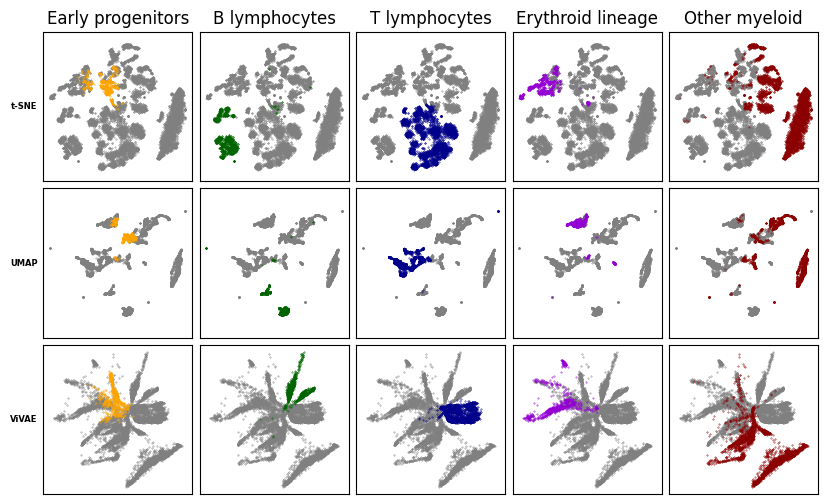

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10,6))
fig.subplots_adjust(wspace=.05, hspace=.05)

embs = [emb_tsne, emb_umap, emb]
methods = ['t-SNE', 'UMAP', 'ViVAE']
cell_subsets = ['Early progenitors', 'B lymphocytes', 'T lymphocytes', 'Erythroid lineage', 'Other myeloid']
idcs = [
    np.array(['stem cell' in lab or 'progenotor' in lab for lab in labs]),
    np.array(['B cell' in lab or 'plasma' in lab for lab in labs]),
    np.array(['T cell' in lab for lab in labs]),
    np.array(['erythro' in lab for lab in labs]),
    np.array([lab in ['neutrophil', 'macrophage', 'monocyte'] for lab in labs])
]
colours = ['orange', 'darkgreen', 'darkblue', 'darkviolet', 'darkred']

for m in range(len(methods)):
    e = embs[m]
    for i in range(len(idcs)):
        ax[m][i].scatter(e[np.bitwise_not(idcs[i]),0], e[np.bitwise_not(idcs[i]),1], c='grey', s=.1)
        ax[m][i].scatter(e[idcs[i],0], e[idcs[i],1], c=colours[i], s=.1)
        ax[m][i].tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        ax[m][i].axis('equal')
        if m==0:
            ax[m][i].set_title(cell_subsets[i])
for a, row in zip(ax[:,0], methods):
    a.annotate(row, xy=(0, .5), xytext=(0, 0), xycoords=a.yaxis.label, textcoords='offset points', size=6, weight='bold', ha='right', va='center')

Each embedding achieves some form of separation between the cell compartments.
t-SNE and UMAP tend to introduce more gaps between cell populations, whereas ViVAE learns a smoother embedding.

The bias toward fragmentaiton can produce misleading results.
For instance, the developmental gradient from hematopoietic stem cell (HSC) through the common myeloid progenitor (CMP) to the erythroid progenitor (EP) is less apparent in the t-SNE layout due to this.
In UMAP, the erythrocyte population is fragmented into two disjoint islands (as shown above), and the HSC->CMP->EP->erythrocyte gradient is obscured, in contrast to t-SNE and ViVAE.
The ViVAE embedding achieves the least fragmented embedding of monocytes, with the least tendency to break up monocytes into distinct island with the granulocyte population in between.
Although all 3 embedding struggle with capturing the developmental pathway from CMPs to neutrophils and monocytes (while maintaing a trajectory toward erythrocytes), ViVAE shows the most continuous connection.
Moreover, the neutrophil-monocyte bifurcation is best represented by ViVAE.

While we believe smoother embeddings are typically more reflective of single-cell biological data, apparent gradients in embeddings can be misinterpreted as well.
One might overinterpret the closeness of cell subtypes in a ViVAE embedding, just as this can occur with a PCA, [diffusion maps](https://bioconductor.org/packages/release/bioc/vignettes/destiny/inst/doc/Diffusion-Maps.html) or [PHATE](https://github.com/KrishnaswamyLab/PHATE) plot.
For instance, the co-location of naive and memory B cells, while indicating similarity in phenotype, is unlikely to show a credible developmental trajectory.
This is because the transition from naive to memory occurs primarily in secondary lymphoid organs (*i.e.*, outside of the bone marrow, which we are looking at here).
However, this potentially confusing co-location can also be seen in the t-SNE and UMAP plot as well!

## **6.** Unsupervised evaluation of DR

To evaluate Local and Global Structure Preservation (SP), we will use ViScore.
ViScore enables quick and accurate approximation of $R_{NX}$ curves, making it possible to measure multi-scale structure preservation in an objective manner.
(This has previously been unfeasible for larger datasets.)

In [21]:
## Compare embeddings w.r.t. preserving structures in the original data
s_tsne  = ViScore.score(hd=pc, ld=emb_tsne)
s_umap  = ViScore.score(hd=pc, ld=emb_umap)
s_vivae = ViScore.score(hd=pc, ld=emb)

In [22]:
## Report ViVAE and UMAP scores
print(f't-SNE:\n\tLocal SP:\t{s_tsne["Sl"]:.3f} \n\tGlobal SP:\t{s_tsne["Sg"]:.3f}')
print(f'UMAP: \n\tLocal SP:\t{s_umap["Sl"]:.3f} \n\tGlobal SP:\t{s_umap["Sg"]:.3f}')
print(f'ViVAE:\n\tLocal SP:\t{s_vivae["Sl"]:.3f}\n\tGlobal SP:\t{s_vivae["Sg"]:.3f}')

t-SNE:
	Local SP:	0.438 
	Global SP:	0.410
UMAP: 
	Local SP:	0.346 
	Global SP:	0.362
ViVAE:
	Local SP:	0.334
	Global SP:	0.561


We report results from a larger benchmark with 11 DR set-ups and 8 scRNA-seq datasets in our study.

## **7.** Supervised evaluation of DR

We use the Extended Neighbourhood-Proportion-Error (xNPE), based on the [NPE](https://www.biorxiv.org/content/10.1101/273862v1) to quantify the distortion in shape and position of embedded population, making use of a 'ground-truth' annotation of cell types.

The xNPE returns a separate value for each population (rather than one value per embedding).
Similarly to the encoder indicatrices, this gives a more specific idea of which parts of the embedding are affected.

In addition to the xNPE, we use neighbourhood composition plots to identify sources of error in embedded populations.
Using a sliding window approach, we calculate proportions of labelled populations across neighbourhoods of different sizes for cells in a population of interest (POI).
These are compared with the original (high-dimensional) neighbourhood structure, in order to pinpoint errors in the relative positioning of populations as they appear in a given embedding.

In [23]:
## Calculate xNPE

xnpe_tsne  = ViScore.xnpe(hd=pc, ld=emb_tsne, annot=labs, knn=knn)
xnpe_umap  = ViScore.xnpe(hd=pc, ld=emb_umap, annot=labs, knn=knn)
xnpe_vivae = ViScore.xnpe(hd=pc, ld=emb, annot=labs, knn=knn)

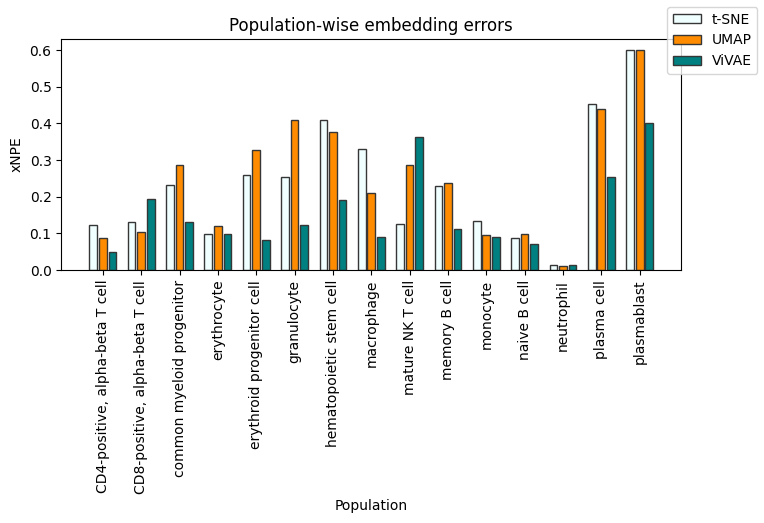

In [26]:
## Plot xNPE results per population

fig, ax = ViScore.plot_xnpe_barplot(
  res=[xnpe_tsne, xnpe_umap, xnpe_vivae],
  res_names=['t-SNE', 'UMAP', 'ViVAE'],
  figsize=(12,6),
  palette=['azure', 'darkorange', 'teal'],
  show=False
)
ax.set_title('Population-wise embedding errors')
fig.set_figwidth(8)
fig.set_figheight(3)
fig

We can see that the ViVAE embedding generally gives lowest error values.
Exceptions to this include the mature NK T cell and CD8+ $\alpha$-$\beta$ T cellpopulations.

While the Local and Global SP scores focus on all points in an embedding in an unbiased way, the xNPE focuses more on points at the edges of each labelled population and, consequently, how the populations are positioned with respect to each other (we present a proof-of-concept study in our paper).
In effect, the xNPE uses cell annotations to focus on structures which are important for telling cell populations apart reliably and putting them in the correct place.

<hr>

By inspecting neighbourhood compositions for populations of interest (POIs), we can further describe the discrepancy between relative positioning of cell populations in the original data and each of the embeddings.
We will do this for *NK T cells* (where ViVAE underperformed) and *granulocytes* (where it outperformed the other two methods).

In [25]:
## Calculate neighbourhood compositions

nc_nkt_hd    = ViScore.neighbourhood_composition(X=pc,       pop='mature NK T cell', annot=labs)
nc_nkt_tsne  = ViScore.neighbourhood_composition(X=emb_tsne, pop='mature NK T cell', annot=labs)
nc_nkt_umap  = ViScore.neighbourhood_composition(X=emb_umap, pop='mature NK T cell', annot=labs)
nc_nkt_vivae = ViScore.neighbourhood_composition(X=emb,      pop='mature NK T cell', annot=labs)

In [68]:
nc_gra_hd    = ViScore.neighbourhood_composition(X=pc,       pop='granulocyte', annot=labs)
nc_gra_tsne  = ViScore.neighbourhood_composition(X=emb_tsne, pop='granulocyte', annot=labs)
nc_gra_umap  = ViScore.neighbourhood_composition(X=emb_umap, pop='granulocyte', annot=labs)
nc_gra_vivae = ViScore.neighbourhood_composition(X=emb,      pop='granulocyte', annot=labs)

In [57]:
## Plot compositions

fig_hd, ax_hd = ViScore.neighbourhood_composition_plot(nc=nc_nkt_hd, show=False)
ax_hd.set_title('NK T cell neighbourhood composition: original')
fig_hd.set_figwidth(5); fig_hd.set_figheight(2)

fig_tsne, ax_tsne = ViScore.neighbourhood_composition_plot(nc=nc_nkt_tsne, show=False)
ax_tsne.set_title('NK T cell neighbourhood composition: t-SNE')
ax_tsne.get_legend().remove()
fig_tsne.set_figwidth(5); fig_tsne.set_figheight(2)

fig_umap, ax_umap = ViScore.neighbourhood_composition_plot(nc=nc_nkt_umap, show=False)
ax_umap.set_title('NK T cell neighbourhood composition: UMAP')
ax_umap.get_legend().remove()
fig_umap.set_figwidth(5); fig_umap.set_figheight(2)

fig_vivae, ax_vivae = ViScore.neighbourhood_composition_plot(nc=nc_nkt_vivae, show=False)
ax_vivae.set_title('NK T cell neighbourhood composition: ViVAE')
ax_vivae.get_legend().remove()
fig_vivae.set_figwidth(5); fig_vivae.set_figheight(2)

We start with the NK T cell population.

First, we plot the neighbourhood composition for our original high-dimensional input.
This is the 'ground truth' that we want the neighbourhood composition plots for our embeddings to resemble as much as possible.

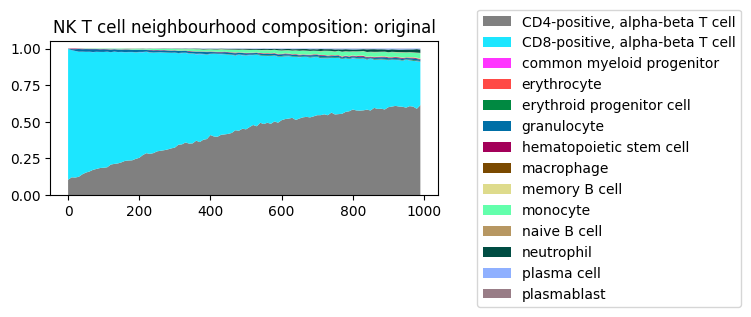

In [58]:
fig_hd

Next, we plot the compositions for our embeddings.

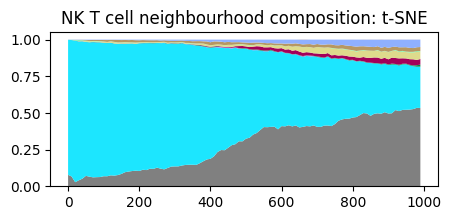

In [59]:
fig_tsne

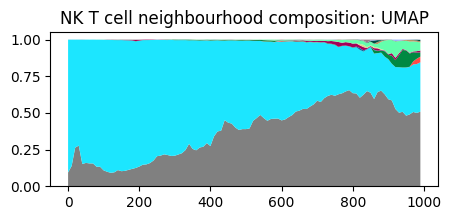

In [60]:
fig_umap

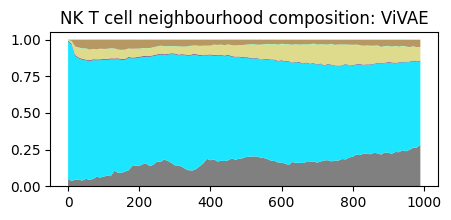

In [61]:
fig_vivae

We can see an exaggerate proximity to the CD8+ population in the ViVAE embedding, as well as artificial intrusion of memory B cells, which also occurs to a lesser extent in the t-SNE embedding.
When we look at the ViVAE embedding, we can see that the T cell compartment, although visibly separate, is indeed rather close to the B cell compartment and runs parallel to it.
This corresponds to the neighbourhood composition profile.

<hr>

Next, we plot the compositions for granulocytes.

In [69]:
## Plot compositions

fig_hd, ax_hd = ViScore.neighbourhood_composition_plot(nc=nc_gra_hd, show=False)
ax_hd.set_title('Granulocyte neighbourhood composition: original')
fig_hd.set_figwidth(5); fig_hd.set_figheight(2)

fig_tsne, ax_tsne = ViScore.neighbourhood_composition_plot(nc=nc_gra_tsne, show=False)
ax_tsne.set_title('Granulocyte neighbourhood composition: t-SNE')
ax_tsne.get_legend().remove()
fig_tsne.set_figwidth(5); fig_tsne.set_figheight(2)

fig_umap, ax_umap = ViScore.neighbourhood_composition_plot(nc=nc_gra_umap, show=False)
ax_umap.set_title('Granulocyte neighbourhood composition: UMAP')
ax_umap.get_legend().remove()
fig_umap.set_figwidth(5); fig_umap.set_figheight(2)

fig_vivae, ax_vivae = ViScore.neighbourhood_composition_plot(nc=nc_gra_vivae, show=False)
ax_vivae.set_title('Granulocyte neighbourhood composition: ViVAE')
ax_vivae.get_legend().remove()
fig_vivae.set_figwidth(5); fig_vivae.set_figheight(2)

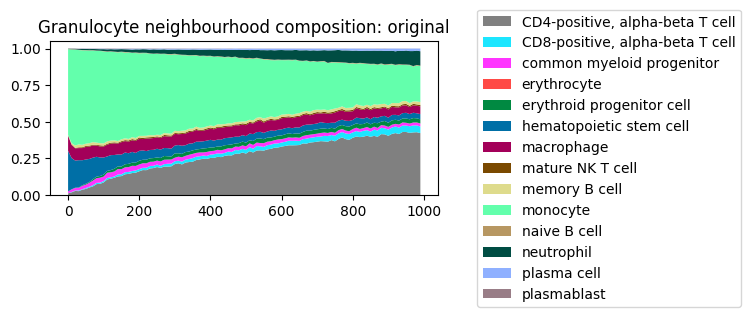

In [70]:
fig_hd

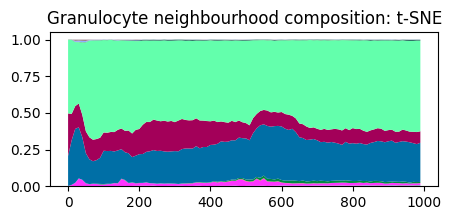

In [71]:
fig_tsne

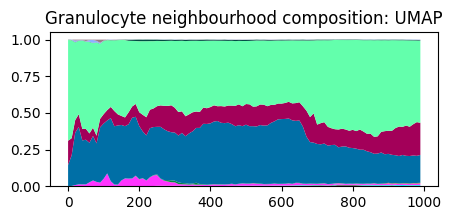

In [72]:
fig_umap

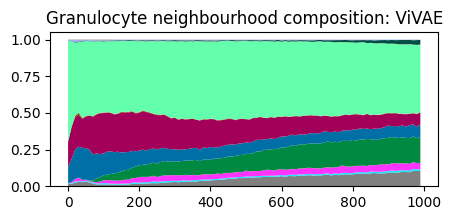

In [73]:
fig_vivae

In this case, the t-SNE and UMAP put the granulocyte population artificially close to HSCs, with an uneven pattern across the *x*-axis due to a over-dispersion of the HSC population across the embedding.
Interestingly, the neighbourhood structure in the original data indicate a proximity to CD4+ T cells, which is decreased in all three embeddings, but the least by ViVAE.

## **7.** Saving and loading a ViVAE model

You might want to save your trained ViVAE model to apply it in a transfer learning scenario.
The easiest way to do this is to use the standard `pickle` module in Python:

In [ ]:
import pickle
with open('model.pkl', 'wb') as output:
  pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

To load your model back up:

In [ ]:
with open('model.pkl', 'rb') as input:
    model = pickle.load(input)